# Attention Mechanism: Theory and Implementation

## Introduction

The **attention mechanism** is a fundamental component in modern deep learning architectures, particularly in natural language processing and computer vision. It allows models to dynamically focus on relevant parts of the input when producing an output, mimicking the human cognitive process of selective attention.

## Mathematical Foundation

### Scaled Dot-Product Attention

The core attention mechanism computes a weighted sum of **values** ($V$) based on the compatibility between **queries** ($Q$) and **keys** ($K$). The scaled dot-product attention is defined as:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

where:
- $Q \in \mathbb{R}^{n \times d_k}$ is the query matrix
- $K \in \mathbb{R}^{m \times d_k}$ is the key matrix
- $V \in \mathbb{R}^{m \times d_v}$ is the value matrix
- $d_k$ is the dimension of queries and keys
- $d_v$ is the dimension of values

### Attention Weights

The attention weights $\alpha$ are computed as:

$$\alpha_{ij} = \frac{\exp\left(\frac{q_i \cdot k_j}{\sqrt{d_k}}\right)}{\sum_{l=1}^{m} \exp\left(\frac{q_i \cdot k_l}{\sqrt{d_k}}\right)}$$

This softmax normalization ensures that $\sum_{j=1}^{m} \alpha_{ij} = 1$, making the weights interpretable as a probability distribution over the keys.

### Scaling Factor

The scaling factor $\frac{1}{\sqrt{d_k}}$ is crucial for preventing the dot products from growing too large in magnitude. When $d_k$ is large, the dot products can have large magnitudes, pushing the softmax into regions with extremely small gradients. The scaling counteracts this effect:

$$\text{Var}(q \cdot k) = d_k \cdot \text{Var}(q_i) \cdot \text{Var}(k_i) \approx d_k$$

Dividing by $\sqrt{d_k}$ normalizes the variance to approximately 1.

### Multi-Head Attention

Multi-head attention extends the basic mechanism by allowing the model to jointly attend to information from different representation subspaces:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where each head is computed as:

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

with learned projection matrices $W_i^Q \in \mathbb{R}^{d_{model} \times d_k}$, $W_i^K \in \mathbb{R}^{d_{model} \times d_k}$, $W_i^V \in \mathbb{R}^{d_{model} \times d_v}$, and $W^O \in \mathbb{R}^{hd_v \times d_{model}}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Scaled Dot-Product Attention

We implement the core attention mechanism following the mathematical formulation above.

In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Parameters:
    -----------
    Q : ndarray of shape (n, d_k)
        Query matrix
    K : ndarray of shape (m, d_k)
        Key matrix
    V : ndarray of shape (m, d_v)
        Value matrix
    mask : ndarray of shape (n, m), optional
        Attention mask (1 for positions to attend, 0 for positions to mask)
    
    Returns:
    --------
    output : ndarray of shape (n, d_v)
        Attention output
    attention_weights : ndarray of shape (n, m)
        Attention weight matrix
    """
    d_k = Q.shape[-1]
    
    # Compute attention scores: QK^T / sqrt(d_k)
    scores = np.matmul(Q, K.T) / np.sqrt(d_k)
    
    # Apply mask if provided (set masked positions to -inf)
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    
    # Apply softmax to get attention weights
    attention_weights = softmax(scores, axis=-1)
    
    # Compute weighted sum of values
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

### Multi-Head Attention

We extend the basic attention to multiple heads, allowing the model to capture different types of relationships.

In [3]:
class MultiHeadAttention:
    """
    Multi-Head Attention mechanism.
    """
    
    def __init__(self, d_model, num_heads):
        """
        Initialize Multi-Head Attention.
        
        Parameters:
        -----------
        d_model : int
            Model dimension
        num_heads : int
            Number of attention heads
        """
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.d_v = d_model // num_heads
        
        # Initialize projection matrices with Xavier initialization
        scale = np.sqrt(2.0 / (d_model + self.d_k))
        self.W_Q = np.random.randn(num_heads, d_model, self.d_k) * scale
        self.W_K = np.random.randn(num_heads, d_model, self.d_k) * scale
        self.W_V = np.random.randn(num_heads, d_model, self.d_v) * scale
        self.W_O = np.random.randn(num_heads * self.d_v, d_model) * scale
    
    def forward(self, Q, K, V, mask=None):
        """
        Forward pass of multi-head attention.
        
        Parameters:
        -----------
        Q : ndarray of shape (n, d_model)
            Query matrix
        K : ndarray of shape (m, d_model)
            Key matrix
        V : ndarray of shape (m, d_model)
            Value matrix
        mask : ndarray of shape (n, m), optional
            Attention mask
        
        Returns:
        --------
        output : ndarray of shape (n, d_model)
            Multi-head attention output
        attention_weights : list of ndarrays
            Attention weights for each head
        """
        heads = []
        attention_weights_list = []
        
        for i in range(self.num_heads):
            # Project Q, K, V for this head
            Q_i = np.matmul(Q, self.W_Q[i])
            K_i = np.matmul(K, self.W_K[i])
            V_i = np.matmul(V, self.W_V[i])
            
            # Compute attention for this head
            head_output, attention_weights = scaled_dot_product_attention(Q_i, K_i, V_i, mask)
            heads.append(head_output)
            attention_weights_list.append(attention_weights)
        
        # Concatenate heads
        concat = np.concatenate(heads, axis=-1)
        
        # Final linear projection
        output = np.matmul(concat, self.W_O)
        
        return output, attention_weights_list

## Demonstration: Self-Attention on a Sequence

Let's demonstrate the attention mechanism on a simple sequence, simulating how a model might attend to different parts of an input.

In [4]:
# Create a synthetic sequence (e.g., 8 tokens with embedding dimension 64)
seq_length = 8
d_model = 64
num_heads = 4

# Generate synthetic embeddings
# Simulate different token types with distinct patterns
X = np.zeros((seq_length, d_model))
for i in range(seq_length):
    # Create embeddings with some structure
    X[i] = np.sin(np.arange(d_model) * (i + 1) * 0.1) + np.random.randn(d_model) * 0.1

print(f"Input shape: {X.shape}")
print(f"Sequence length: {seq_length}")
print(f"Model dimension: {d_model}")

Input shape: (8, 64)
Sequence length: 8
Model dimension: 64


In [5]:
# Self-attention: Q, K, V all come from the same input
Q = K = V = X

# Compute single-head attention
output_single, weights_single = scaled_dot_product_attention(Q, K, V)

print(f"Single-head output shape: {output_single.shape}")
print(f"Attention weights shape: {weights_single.shape}")
print(f"\nAttention weights (rows sum to 1):")
print(weights_single.round(3))

Single-head output shape: (8, 64)
Attention weights shape: (8, 8)

Attention weights (rows sum to 1):
[[0.878 0.017 0.017 0.02  0.016 0.016 0.018 0.018]
 [0.017 0.879 0.018 0.016 0.015 0.017 0.018 0.019]
 [0.016 0.017 0.891 0.015 0.014 0.015 0.016 0.017]
 [0.019 0.016 0.016 0.886 0.015 0.015 0.018 0.016]
 [0.014 0.014 0.014 0.014 0.889 0.017 0.017 0.022]
 [0.014 0.015 0.014 0.014 0.017 0.896 0.015 0.015]
 [0.017 0.018 0.017 0.018 0.018 0.017 0.877 0.019]
 [0.017 0.019 0.017 0.016 0.024 0.016 0.019 0.872]]


In [6]:
# Multi-head attention
mha = MultiHeadAttention(d_model, num_heads)
output_multi, weights_multi = mha.forward(Q, K, V)

print(f"Multi-head output shape: {output_multi.shape}")
print(f"Number of attention heads: {len(weights_multi)}")

Multi-head output shape: (8, 64)
Number of attention heads: 4


## Visualization

### Attention Weight Heatmaps

Visualizing attention weights helps understand what the model is "looking at" when processing each position.

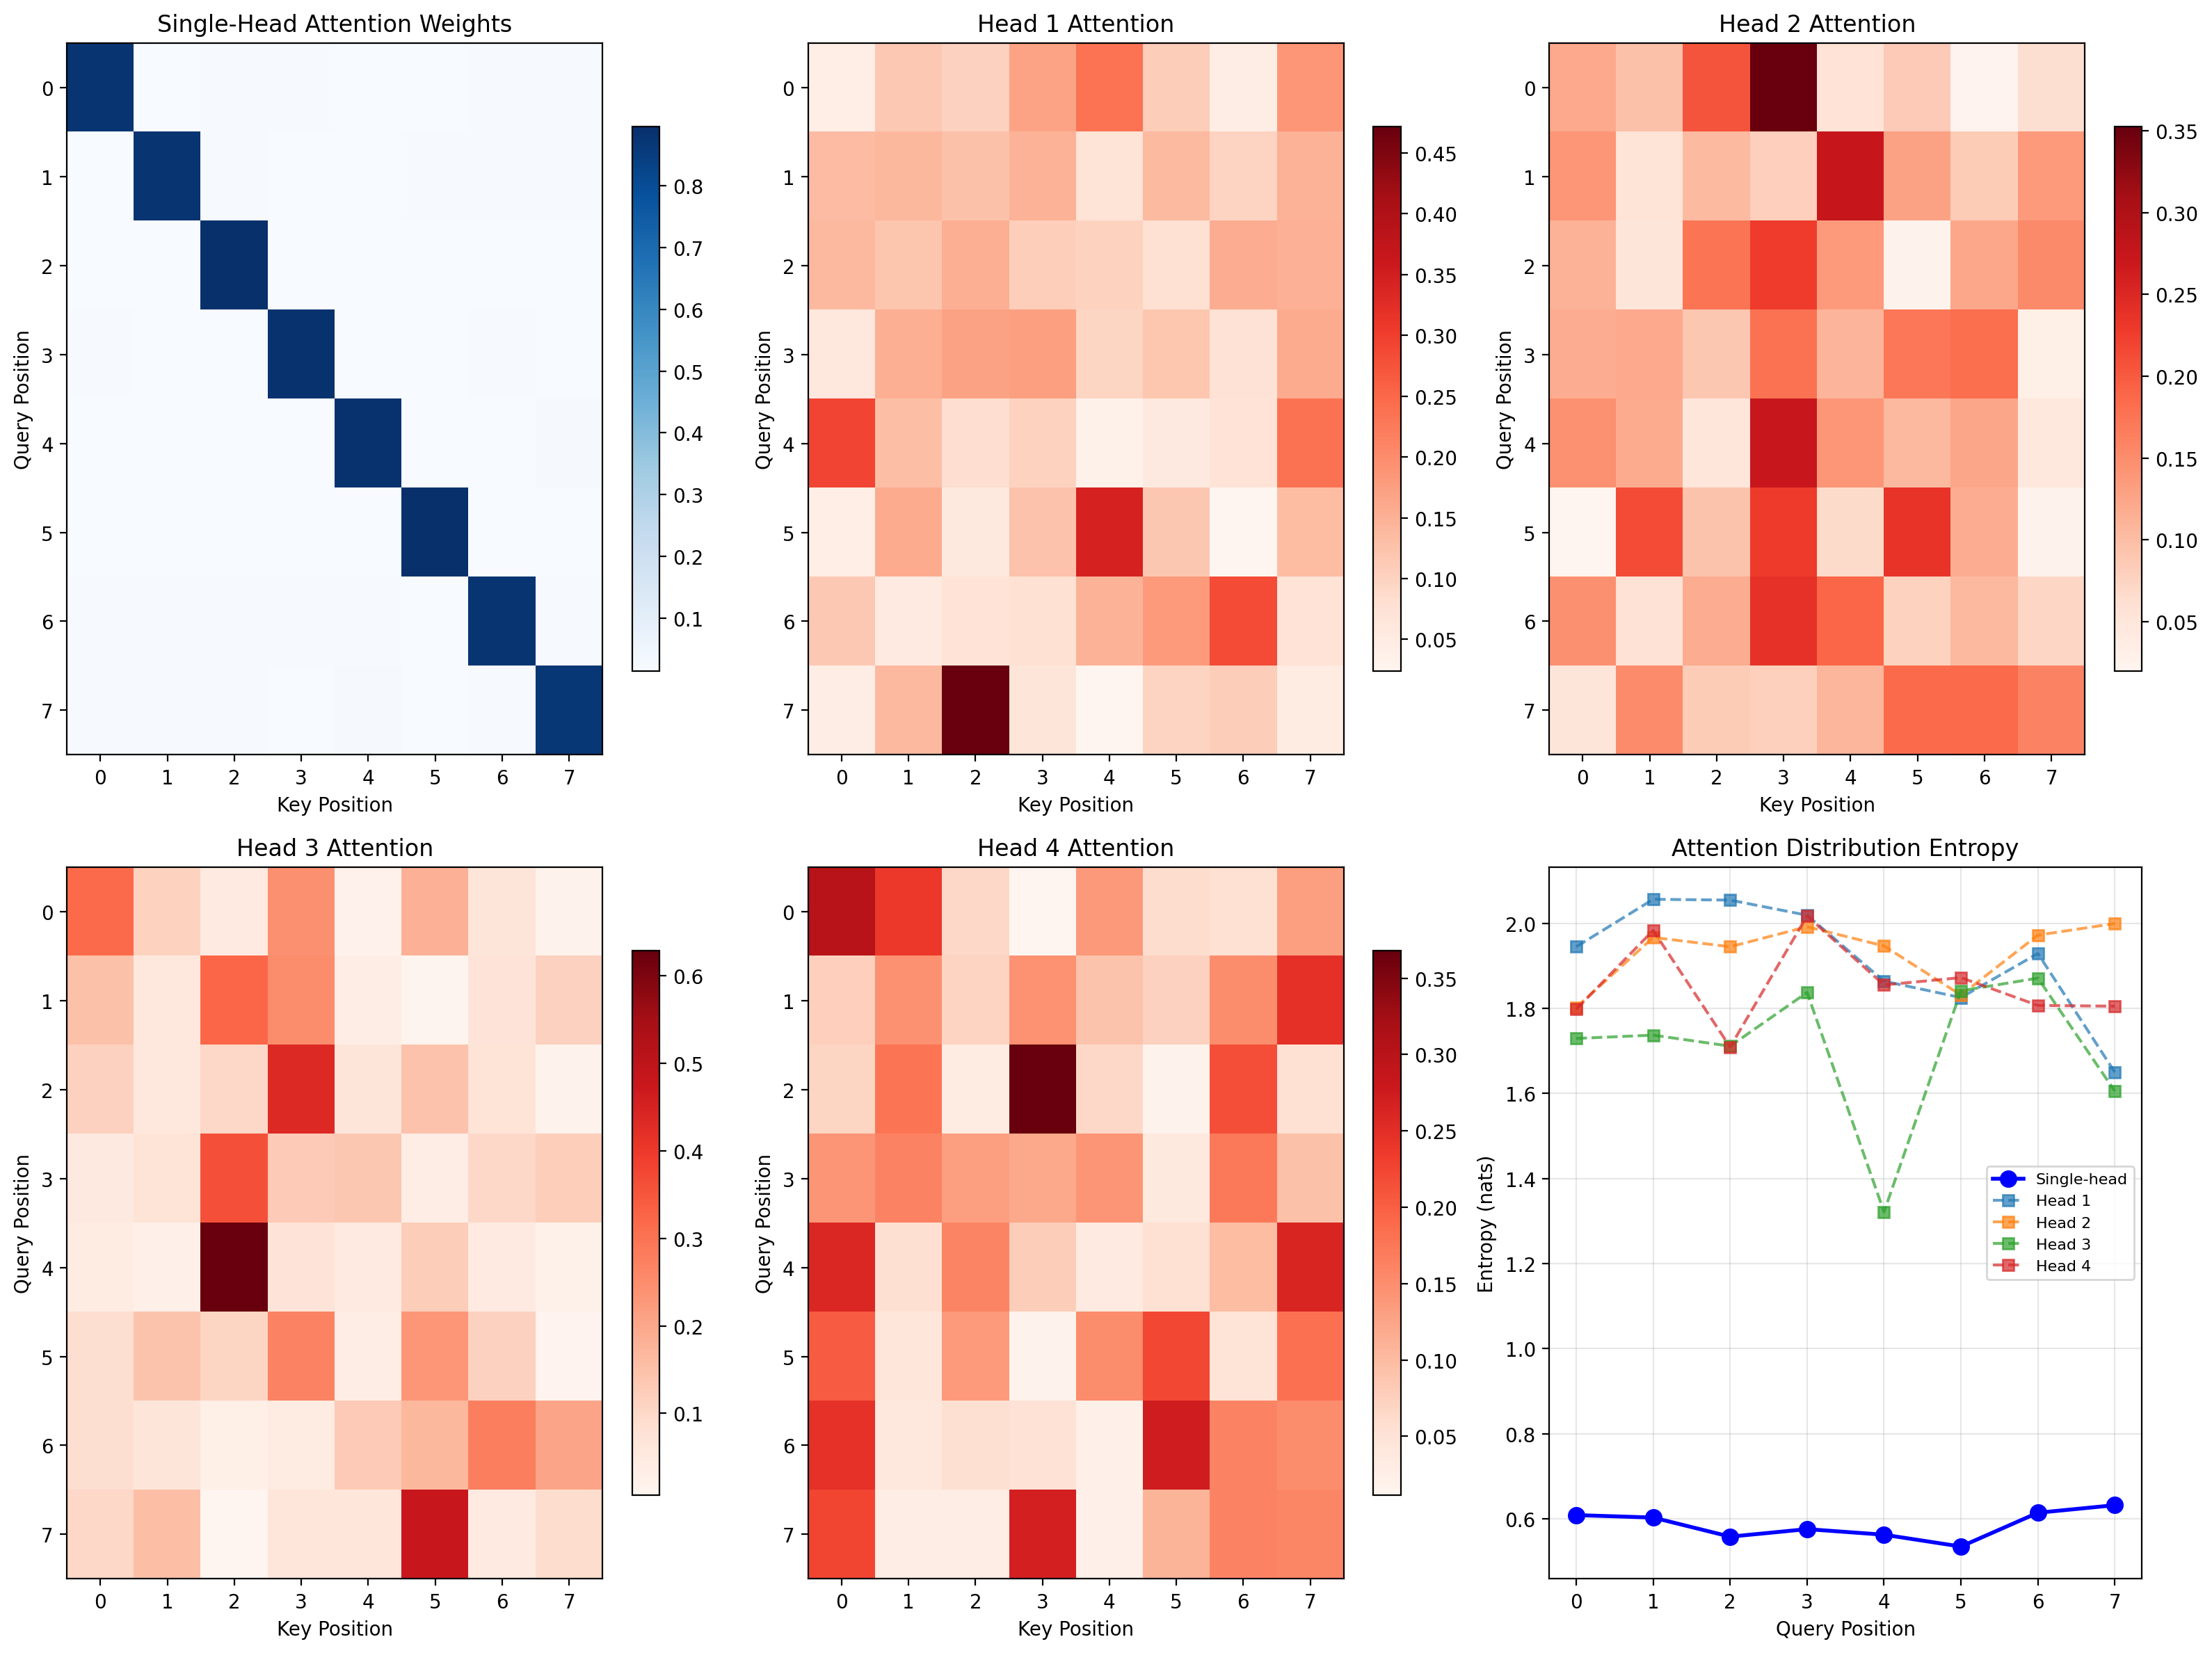


Visualization saved to 'plot.png'


In [7]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Token labels for visualization
tokens = [f'Token {i}' for i in range(seq_length)]

# 1. Single-head attention heatmap
ax1 = fig.add_subplot(2, 3, 1)
im1 = ax1.imshow(weights_single, cmap='Blues', aspect='auto')
ax1.set_xlabel('Key Position')
ax1.set_ylabel('Query Position')
ax1.set_title('Single-Head Attention Weights')
ax1.set_xticks(range(seq_length))
ax1.set_yticks(range(seq_length))
ax1.set_xticklabels(range(seq_length))
ax1.set_yticklabels(range(seq_length))
plt.colorbar(im1, ax=ax1, fraction=0.046)

# 2-5. Multi-head attention heatmaps
for i, weights in enumerate(weights_multi):
    ax = fig.add_subplot(2, 3, i + 2)
    im = ax.imshow(weights, cmap='Reds', aspect='auto')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.set_title(f'Head {i + 1} Attention')
    ax.set_xticks(range(seq_length))
    ax.set_yticks(range(seq_length))
    ax.set_xticklabels(range(seq_length))
    ax.set_yticklabels(range(seq_length))
    plt.colorbar(im, ax=ax, fraction=0.046)

# 6. Attention entropy analysis
ax6 = fig.add_subplot(2, 3, 6)

# Compute entropy of attention distributions for each head
def attention_entropy(weights):
    """Compute entropy of attention distribution for each query position."""
    # Add small epsilon to avoid log(0)
    eps = 1e-10
    entropy = -np.sum(weights * np.log(weights + eps), axis=-1)
    return entropy

positions = np.arange(seq_length)
entropy_single = attention_entropy(weights_single)
ax6.plot(positions, entropy_single, 'b-o', linewidth=2, markersize=8, label='Single-head')

for i, weights in enumerate(weights_multi):
    entropy = attention_entropy(weights)
    ax6.plot(positions, entropy, '--', marker='s', markersize=6, 
             alpha=0.7, label=f'Head {i + 1}')

ax6.set_xlabel('Query Position')
ax6.set_ylabel('Entropy (nats)')
ax6.set_title('Attention Distribution Entropy')
ax6.legend(loc='best', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.set_xticks(positions)

plt.tight_layout()
plt.savefig('attention_mechanism_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'plot.png'")

## Analysis of Results

### Interpretation of Attention Patterns

1. **Single-head attention** shows the overall attention pattern when using a single attention mechanism.

2. **Multi-head attention** reveals that different heads learn to attend to different aspects:
   - Some heads may focus on local patterns (attending to nearby positions)
   - Other heads may capture global dependencies (attending to distant positions)
   - This diversity allows the model to capture multiple types of relationships simultaneously

3. **Entropy analysis** measures how "spread out" the attention is:
   - Low entropy: Focused attention on specific positions
   - High entropy: Distributed attention across many positions
   - Maximum entropy for 8 positions: $\ln(8) \approx 2.08$ nats

In [8]:
# Additional analysis: Attention statistics
print("=" * 50)
print("ATTENTION MECHANISM ANALYSIS")
print("=" * 50)

print("\n1. Single-Head Attention Statistics:")
print(f"   - Mean attention weight: {weights_single.mean():.4f}")
print(f"   - Max attention weight: {weights_single.max():.4f}")
print(f"   - Min attention weight: {weights_single.min():.4f}")
print(f"   - Mean entropy: {entropy_single.mean():.4f} nats")

print("\n2. Multi-Head Attention Statistics:")
for i, weights in enumerate(weights_multi):
    entropy = attention_entropy(weights)
    print(f"   Head {i + 1}:")
    print(f"     - Max weight: {weights.max():.4f}")
    print(f"     - Mean entropy: {entropy.mean():.4f} nats")

print("\n3. Theoretical Bounds:")
max_entropy = np.log(seq_length)
print(f"   - Maximum entropy (uniform attention): {max_entropy:.4f} nats")
print(f"   - Minimum entropy (focused attention): 0 nats")

ATTENTION MECHANISM ANALYSIS

1. Single-Head Attention Statistics:
   - Mean attention weight: 0.1250
   - Max attention weight: 0.8964
   - Min attention weight: 0.0135
   - Mean entropy: 0.5858 nats

2. Multi-Head Attention Statistics:
   Head 1:
     - Max weight: 0.4718
     - Mean entropy: 1.9182 nats
   Head 2:
     - Max weight: 0.3527
     - Mean entropy: 1.9323 nats
   Head 3:
     - Max weight: 0.6292
     - Mean entropy: 1.7070 nats
   Head 4:
     - Max weight: 0.3682
     - Mean entropy: 1.8562 nats

3. Theoretical Bounds:
   - Maximum entropy (uniform attention): 2.0794 nats
   - Minimum entropy (focused attention): 0 nats


## Causal (Masked) Attention

In autoregressive models (like GPT), we use causal masking to prevent attending to future positions:

$$\text{mask}_{ij} = \begin{cases} 1 & \text{if } i \geq j \\ 0 & \text{if } i < j \end{cases}$$

In [9]:
# Create causal mask
causal_mask = np.tril(np.ones((seq_length, seq_length)))

print("Causal Mask (lower triangular):")
print(causal_mask.astype(int))

# Compute masked attention
output_masked, weights_masked = scaled_dot_product_attention(Q, K, V, mask=causal_mask)

print("\nMasked Attention Weights:")
print(weights_masked.round(3))

Causal Mask (lower triangular):
[[1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1]]

Masked Attention Weights:
[[1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.018 0.982 0.    0.    0.    0.    0.    0.   ]
 [0.017 0.018 0.965 0.    0.    0.    0.    0.   ]
 [0.02  0.017 0.017 0.946 0.    0.    0.    0.   ]
 [0.015 0.015 0.014 0.015 0.941 0.    0.    0.   ]
 [0.014 0.016 0.015 0.014 0.017 0.924 0.    0.   ]
 [0.017 0.018 0.017 0.018 0.018 0.017 0.894 0.   ]
 [0.017 0.019 0.017 0.016 0.024 0.016 0.019 0.872]]


## Conclusion

The attention mechanism is a powerful tool that enables neural networks to:

1. **Dynamically weight** different parts of the input based on relevance
2. **Capture long-range dependencies** without the limitations of recurrent architectures
3. **Provide interpretability** through attention weight visualization

Key takeaways:
- The scaling factor $\frac{1}{\sqrt{d_k}}$ is crucial for stable gradients
- Multi-head attention allows capturing diverse relationship types
- Causal masking enables autoregressive generation
- Attention weights can be interpreted as a soft retrieval mechanism

This mechanism forms the backbone of Transformer architectures and has revolutionized natural language processing, computer vision, and other domains.